In [58]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
import scipy.signal as sig
from recognize_handwriting import *

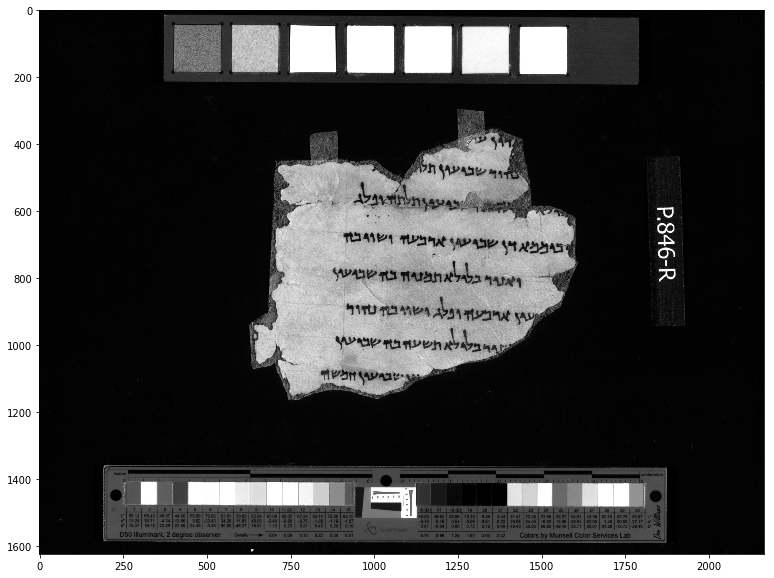

In [140]:
path = 'image-data/test11.jpg'
image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
plt.figure(figsize = (500,10))
plt.imshow(image, cmap='gray', aspect = 1)
plt.show()

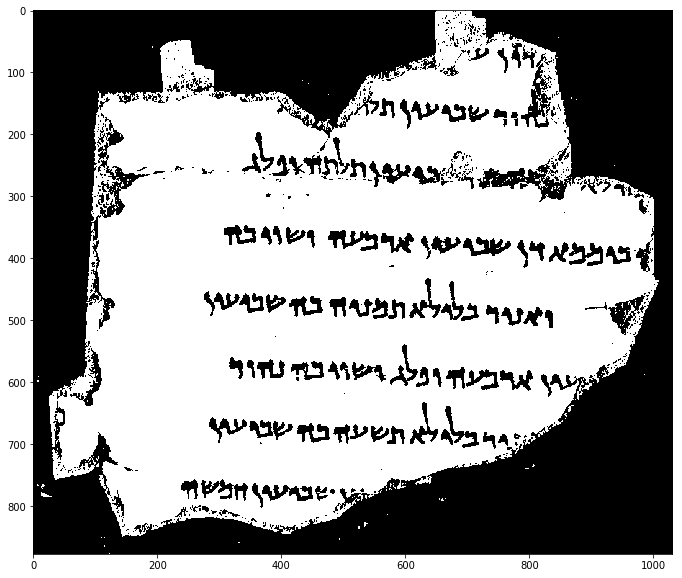

In [141]:
preprocessed_img = extract_parchment(image, 100)
plt.figure(figsize = (500,10))
plt.imshow(preprocessed_img, cmap='gray', aspect = 1)
plt.show()

In [142]:
parchment = extract_parchment(image, 100)
# detect words and characters in the parchment
boxes, centroids, avg_height, avg_width = segment_words(parchment.copy())
print("Average word height and width:", avg_height, avg_width)
# divide parchment into line strips containing words and characters
strips, whitened_parchment, line_image = segment_line_strips(boxes, centroids, parchment, avg_height, avg_width)

Average word height and width: 39.0 47.75
[-100, 1]
[281.1735992014882, 2]
[379.35489123970194, 2]
[480.4698604347509, 3]
[586.3203471432957, 2]
[-100, 1]


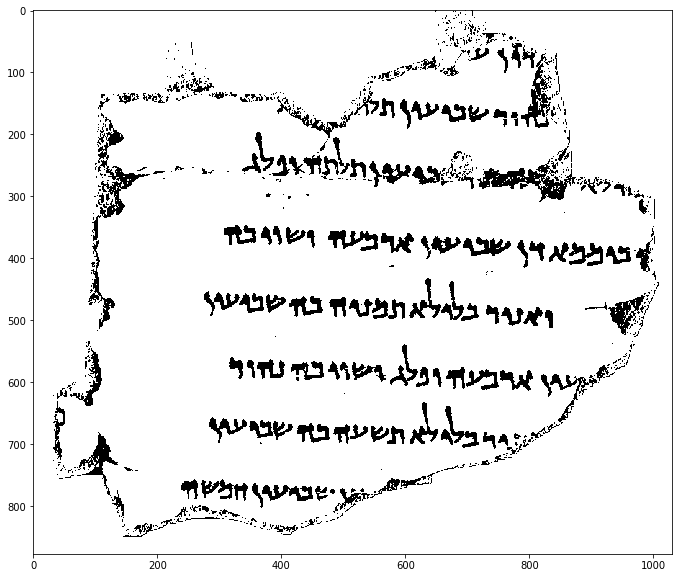

In [143]:
plt.figure(figsize = (500,10))
plt.imshow(whitened_parchment, cmap='gray', aspect = 1)
plt.show()

In [144]:
def find_peak(hist, peak_window=5, grey_threshold=100):
    peak_kernel = peak_window // 2
    rg = range(len(hist))
    list_peaks = []
    for i in rg:
        max_count = 0
        for j in range(i, i + peak_window):
            if max_count < hist[i]:
                max_count = hist[i]

        # find if the max is peak
        peak_flag = True
        for k in range(peak_kernel):
            idx_diff = k + 1
            idx_min = 0 if (i - idx_diff) < 0 else i - idx_diff
            idx_max = (len(hist)-1) if (i + idx_diff) > (len(hist)-1) else i + idx_diff
            if max_count <= hist[idx_min] or max_count <= hist[idx_max]:
                peak_flag = False
        if peak_flag:
            list_peaks.append([i, max_count])
#     list_peaks.sort(key=lambda x: x[1], reverse=True)
    
    return list_peaks

In [145]:
def rotate_img(img, degree=10, interval=1):
    degree_start = abs(degree)
    degree_end = -(degree_start + 1)
    interval = int(interval)
    if interval < 1:
        raise ValueError(
                "parameter interval should be at least 1, now it's {}".format(interval))
    
    images_to_return = []
    for i in range(degree_start, degree_end, -interval):
        processed = img.copy()    
        processed = rotate(processed, i, reshape=True, cval=255)
        images_to_return.append(processed)
    return images_to_return

In [146]:
def rotation_procedure(image, avg_height):
    rotated_img_list = rotate_img(image, 10, 1)
    best_img = image.copy()
    line_strips = []
    max_range = 0    
    for rotated_img in rotated_img_list:
        
      # verticalProfile = np.sum(whitened_parchment, axis=0)
        horizontalProfile = np.sum(rotated_img, axis=1)        
        temp_max_range = horizontalProfile.max() - horizontalProfile.min()
        
        if temp_max_range > max_range:
            max_range = temp_max_range
            best_img = rotated_img
            best_horizontalProfile = horizontalProfile
            # plt.plot(range(0,columns), verticalProfile)

    [rows, columns] = best_img.shape
    plt.plot(best_horizontalProfile, range(0,rows))
    plt.show()
    # adjust window size
    peak_list = find_peak(best_horizontalProfile, int(avg_height))
    copy_img = best_img.copy()
    height, width = best_img.shape
    min_height = 0
    for peak_idx in range(len(peak_list)):
        if peak_idx == 0:
            min_height = peak_list[peak_idx][0]
        else:
            max_height = peak_list[peak_idx][0]
            line_strips.append([min_height, max_height])
            cv2.line(copy_img,(0, min_height),(width, min_height),(0, 200,0), 4)   
            cv2.line(copy_img,(0, max_height),(width, max_height),(0, 200,0), 4) 
            min_height = max_height

    plt.figure(figsize = (500,10))
    plt.imshow(copy_img, cmap='gray', aspect = 1)
    plt.show()    
    
    return best_img, line_strips

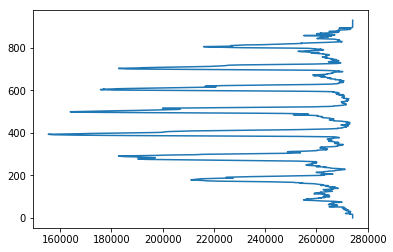

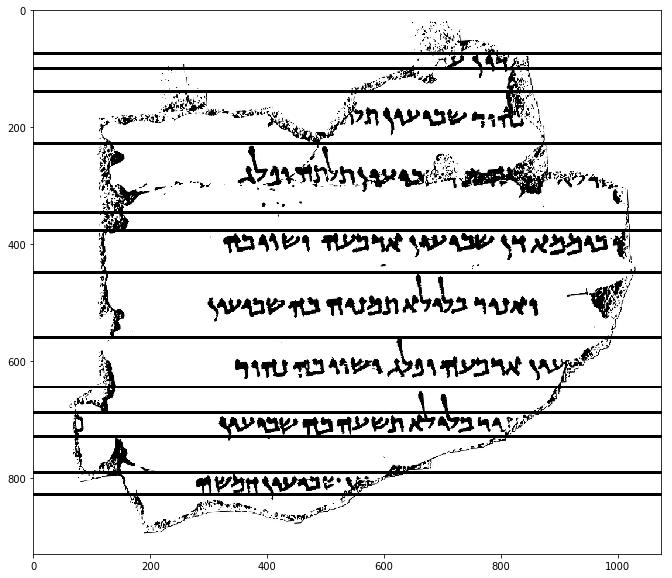

In [147]:
best_img, line_strips = rotation_procedure(whitened_parchment, avg_height)